In [1]:
import pandas as pd
from sklearn.impute import SimpleImputer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

## Preprocessing the {Pt, Pd, Au, Ir} Features and Tafel Slope Target

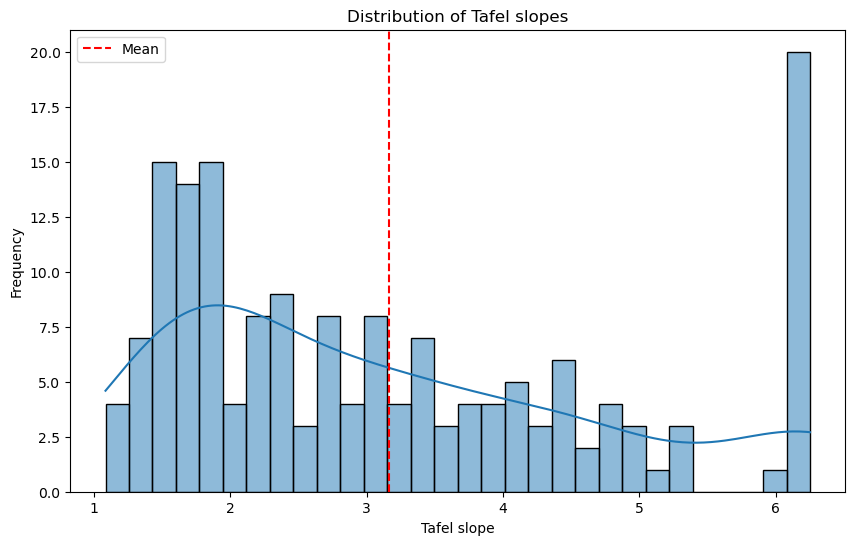

count    169.000000
mean       3.166150
std        1.576668
min        1.086023
25%        1.787369
50%        2.769431
75%        4.250224
max        6.250731
Name: Tafel slope, dtype: float64

Percentage of each Tafel slope category:
Target Category
1 to 4    71.005917
4 to 7    28.994083
Name: proportion, dtype: float64


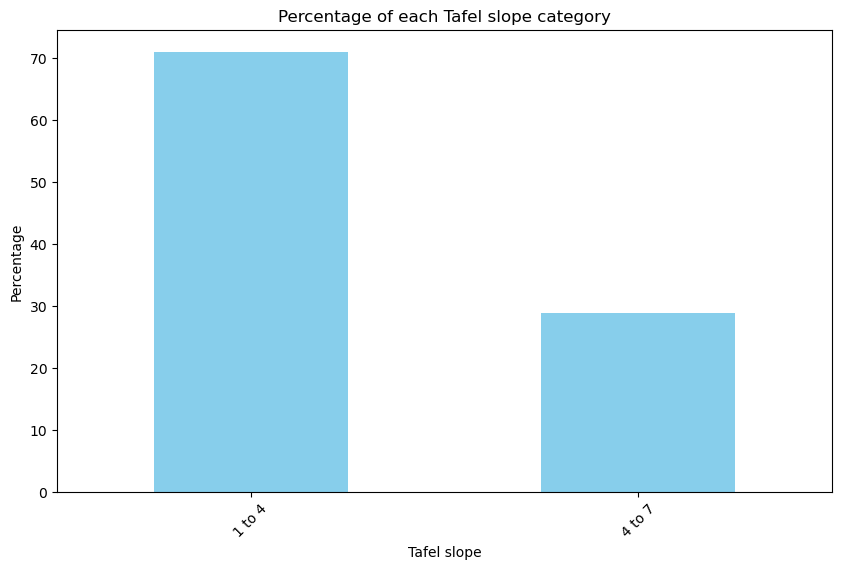

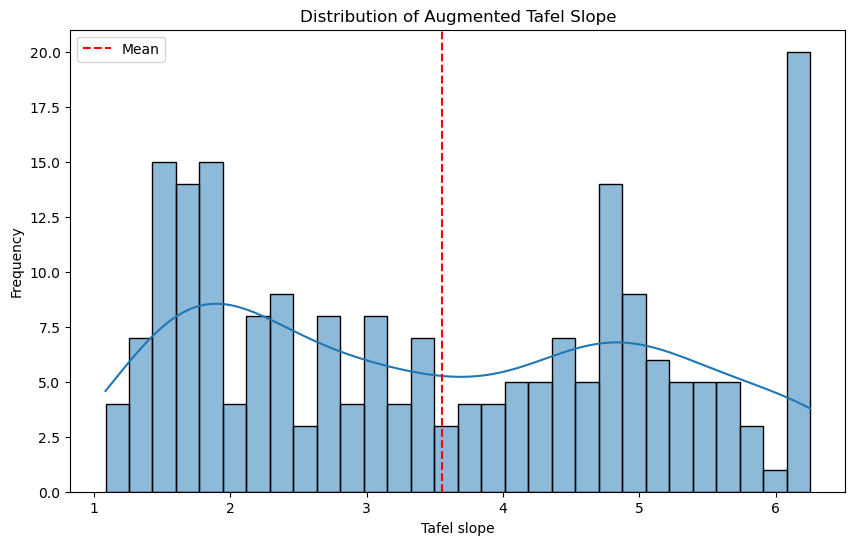

           Pt        Pd        Au        Ir  Tafel slope
0    0.137500  0.101500  0.094000  0.667000     2.140367
1    0.348700  0.165800  0.040300  0.445300     1.507503
2    0.374200  0.114400  0.455000  0.056400     2.733981
3    0.133000  0.066700  0.678800  0.121500     6.250731
4    0.154400  0.166900  0.551700  0.127000     5.162049
..        ...       ...       ...       ...          ...
206  0.363972  0.068759  0.260131  0.307138     5.462190
207  0.310771  0.222199  0.465736  0.001293     4.597877
208  0.292728  0.066477  0.504209  0.136586     5.110008
209  0.035901  0.037440  0.804223  0.122436     5.740963
210  0.182672  0.172187  0.453682  0.191459     5.053743

[211 rows x 5 columns]


In [2]:
comp_tafel_df = pd.read_csv('composition_Tafel.csv')
features = ['Pt', 'Ir', 'Au', 'Pd']
#Drop any rows that have only NaN values
comp_tafel_df = comp_tafel_df[~(comp_tafel_df['Pt'].isna() & comp_tafel_df['Tafel slope'].isna())]

#Impute composition data using mean values. Impute Tafel slope below current density threshold with max(slope).
imputer = SimpleImputer(strategy='mean')
columns_to_impute = comp_tafel_df.drop(columns=['Tafel slope']) #All columns except Tafel slope
imputed_df = pd.DataFrame(imputer.fit_transform(columns_to_impute), index=columns_to_impute.index, \
                          columns=columns_to_impute.columns)
comp_tafel_df = pd.concat([imputed_df, comp_tafel_df[['Tafel slope']]], axis=1)
comp_tafel_df['Tafel slope'] = comp_tafel_df['Tafel slope'].fillna(comp_tafel_df['Tafel slope'].max())

#Statistical analysis of Tafel slope distributions
plt.figure(figsize=(10, 6))
sns.histplot(comp_tafel_df['Tafel slope'], bins=30, kde=True)
plt.title('Distribution of Tafel slopes')
plt.xlabel('Tafel slope')
plt.ylabel('Frequency')
plt.axvline(x=comp_tafel_df['Tafel slope'].mean(), color='red', linestyle='--', label='Mean')
plt.legend()
plt.show()
stats = comp_tafel_df['Tafel slope'].describe(percentiles=[0.25, 0.5, 0.75])
print(stats)
bins = [1, 4, 7]
labels = ['1 to 4', '4 to 7']
comp_tafel_df['Target Category'] = pd.cut(comp_tafel_df['Tafel slope'], bins=bins, labels=labels)
category_counts = comp_tafel_df['Target Category'].value_counts(normalize=True) * 100 
print("\nPercentage of each Tafel slope category:")
print(category_counts)
plt.figure(figsize=(10, 6))
category_counts.plot(kind='bar', color='skyblue')
plt.title('Percentage of each Tafel slope category')
plt.xlabel('Tafel slope')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.show()

#Regression-based Synthetic Data Generation to oversample the underrepresented data.
df_minority = comp_tafel_df[comp_tafel_df['Tafel slope'] > 4]
X_minority = df_minority[features]
y_minority = df_minority['Tafel slope']
X_train_min, X_test_min, y_train_min, y_test_min = train_test_split(X_minority, y_minority, \
                                                                      test_size=0.3, random_state=42)
model = RandomForestRegressor()
model.fit(X_train_min, y_train_min)
n_synthetic = int(np.abs(category_counts.iloc[0] - category_counts.iloc[1])) #Number of synthetic rows to add.
'''Generate synthetic features by sampling from the minority feature distribution
   The features follow the Dirichlet Distribution so they sum to 1.'''
alpha = np.array([1.0] * len(features))  #Equal concentration parameters for non-negativity and normalization
synthetic_features = np.random.dirichlet(alpha, n_synthetic)
synthetic_features_df = pd.DataFrame(synthetic_features, columns=features)
synthetic_targets = model.predict(synthetic_features_df)
synthetic_df = pd.DataFrame(synthetic_features_df, columns=features)
synthetic_df['Tafel slope'] = synthetic_targets
augmented_comp_tafel_df = pd.concat([comp_tafel_df, synthetic_df], ignore_index=True)
augmented_comp_tafel_df.drop(columns=['Target Category'], inplace=True)

# Check the distribution of the target variable
plt.figure(figsize=(10, 6))
sns.histplot(augmented_comp_tafel_df['Tafel slope'], bins=30, kde=True)
plt.title('Distribution of Augmented Tafel Slope')
plt.xlabel('Tafel slope')
plt.ylabel('Frequency')
plt.axvline(x=augmented_comp_tafel_df['Tafel slope'].mean(), color='red', linestyle='--', label='Mean')
plt.legend()
plt.show()

print(augmented_comp_tafel_df)